<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/RF222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import yfinance as yf
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [ ]:
# Example: Gold Fields (GFI.JO) – replace ticker if needed
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Reset index to keep Date
data.reset_index(inplace=True)


/tmp/ipython-input-3940022676.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [ ]:
df = data.copy()

# 1. Spreads
df['High_Low'] = df['High'] - df['Low']
df['Open_Close'] = df['Open'] - df['Close']

# 2. Moving Averages
df['SMA_5'] = df['Close'].rolling(5).mean()
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_100'] = df['Close'].rolling(100).mean()
df['SMA_200'] = df['Close'].rolling(200).mean()

# 3. Exponential Moving Averages
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# 4. Rolling Std (Volatility)
df['RollingStd_20'] = df['Close'].rolling(20).std()

# 5. Lag Features (Close & Volume)
for lag in range(1, 6):
    df[f'Close_t-{lag}'] = df['Close'].shift(lag)
    df[f'Volume_t-{lag}'] = df['Volume'].shift(lag)
    df[f'Return_t-{lag}'] = df['Close'].pct_change(lag)

# Drop NA rows
df.dropna(inplace=True)

# Target: 1 if next-day close > today’s close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df.dropna(inplace=True)


In [ ]:
train = df[df['Date'] < "2024-01-01"]
test = df[df['Date'] >= "2024-01-01"]

feature_pool = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5','SMA_10','SMA_20','SMA_50','SMA_100','SMA_200',
    'EMA_5','EMA_20','EMA_50',
    'RollingStd_20','High_Low','Open_Close',
    'Close_t-1','Close_t-2','Close_t-3','Close_t-4','Close_t-5',
    'Volume_t-1','Volume_t-2','Volume_t-3','Volume_t-4','Volume_t-5',
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5'
]

X_train_full = train[feature_pool]
y_train = train['Target']
X_test_full = test[feature_pool]
y_test = test['Target']


In [ ]:
 import random

best_score = 0
best_features = None
best_model = None

# Try 500 random feature subsets
for _ in range(100):
    r = random.randint(2, 5)   # choose number of features
    combo = random.sample(feature_pool, r)  # random subset

    X_train = X_train_full[list(combo)]
    X_test = X_test_full[list(combo)]

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    if acc > best_score:
        best_score = acc
        best_features = combo
        best_model = model

print("Best Accuracy:", best_score)
print("Best Feature Set:", best_features)


Best Accuracy: 0.5622489959839357
Best Feature Set: ['High', 'SMA_200', 'Close_t-4', 'Close_t-3', 'RollingStd_20']


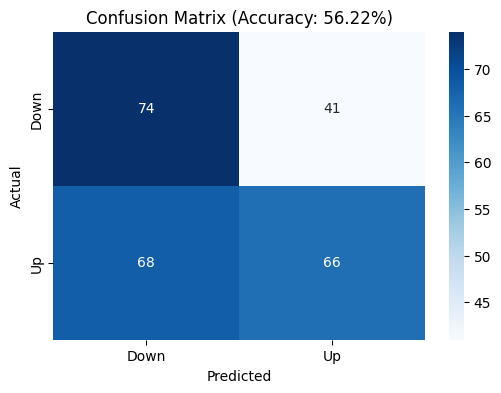

In [ ]:
# Predict with best model
X_test_best = X_test_full[list(best_features)]
y_pred = best_model.predict(X_test_best)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down","Up"], yticklabels=["Down","Up"])
plt.title(f"Confusion Matrix (Accuracy: {best_score:.2%})")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()
